In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# IMPT: make shortcut of the BT4012 Project folder inside your google drive so the stuff below works
drive.mount("/content/drive")
trainData = pd.read_csv("/content/drive/My Drive/BT4012 Project/fraudTrain.csv")
testData = pd.read_csv("/content/drive/My Drive/BT4012 Project/fraudTest.csv")
# maybe can combine both sets of data then split on our own for more credits?
allData = pd.concat([trainData, testData])

Mounted at /content/drive


In [ ]:
def age_group(row):
    rows = row["age"]
    if rows <20:
        return "less than 20"
    elif rows >=20 and rows<30:
        return "20 to 30"
    elif rows >=30 and rows<40:
        return "30 to 40"
    elif rows >=40 and rows<50:
        return "40 to 50"
    elif rows >=50 and rows<60:
        return "50 to 60"
    elif rows >=60 and rows<70:
        return "60 to 70"
    elif rows >=70 and rows<80:
        return "70 to 80"
    elif rows >=80 and rows<90:
        return "80 to 90"
    else:
        return "greater than 90"

In [ ]:
from sklearn.model_selection import train_test_split

# print(allData.corr())

# age grp
allData["age"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).year-pd.DatetimeIndex(allData["dob"]).year
allData["age_group"] = allData.apply(age_group,axis=1)

# trans times / age
allData["trans_hour"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).hour
allData["trans_yrmth"] = pd.DatetimeIndex(allData['trans_date_trans_time']).strftime('%Y-%m')
allData["weekday"] = pd.DatetimeIndex(allData["trans_date_trans_time"]).weekday
allData["date"] = pd.to_datetime(allData['trans_date_trans_time']).dt.date

# drop redundant index column
allData.drop(labels="Unnamed: 0", axis=1, inplace=True)

# calculating the distance between the merchant location and transaction location
allData["latitude_difference"] = abs(allData["lat"]-allData["merch_lat"])
allData["longitude_difference"] = abs(allData["long"]-allData["merch_long"])

# it is estimated that difference between each degree of longitude and lattitude is approximately 69 miles which is 110 km
# applying pythogoras theorem
allData["distance"] = np.sqrt(pow(allData["latitude_difference"]*110,2)+pow(allData["longitude_difference"]*110,2))
allData['distance'].describe()

allData.category = allData.category.astype("category")
allData.gender = allData.gender.astype("category")
allData.state = allData.state.astype("category")
allData.age_group = allData.age_group.astype("category")
allData.trans_yrmth = allData.trans_yrmth.astype("category")
allData.weekday = allData.weekday.astype("category")
allData.job = allData.job.astype("category")
allData.city = allData.city.astype("category")
allData.is_fraud = allData.is_fraud.astype("category")
allData.trans_hour = allData.trans_hour.astype("category")

#can ignore others, just use train, validation, test
train, test = train_test_split(allData, test_size=0.2, random_state=4012)
del(allData)

onlyFraud = train[train.is_fraud == 1]
noFraud = train[train.is_fraud != 1]

print(onlyFraud)

       trans_date_trans_time            cc_num  \
288598   2019-05-21 23:40:29  6011438889172900   
644699   2019-10-01 01:45:49   346208242862904   
366597   2019-06-19 01:11:01  6506116513503136   
621562   2019-09-21 17:41:09  3565943051129759   
10057    2019-01-07 04:34:48  3597980945245815   
...                      ...               ...   
205282   2019-04-15 03:05:13  3548710338694745   
389704   2020-11-21 03:17:38    30235268718158   
204807   2020-09-01 01:10:19  4003989662068504   
93343    2019-02-24 22:33:25   180036456789979   
351029   2019-06-14 00:17:50  6011948324228984   

                                  merchant       category     amt      first  \
288598                fraud_Abbott-Steuber  personal_care   20.17    Allison   
644699                   fraud_Collier Inc    grocery_net   10.54    Tabitha   
366597               fraud_Dooley-Thompson       misc_net  773.63   Kimberly   
621562                     fraud_Lynch Ltd   shopping_pos  905.66      David   

In [ ]:
train.drop(["trans_date_trans_time", "first", "last", "unix_time", "street", "cc_num", "merchant", "age", "city_pop", "zip", "dob", "trans_num"], axis=1, inplace=True)
train.drop(["lat","long","merch_lat","merch_long","latitude_difference","longitude_difference", 'date'], axis=1, inplace=True)

test.drop(["trans_date_trans_time", "first", "last", "unix_time", "street", "cc_num", "merchant", "age", "city_pop", "zip", "dob", "trans_num"], axis=1, inplace=True)
test.drop(["lat","long","merch_lat","merch_long","latitude_difference","longitude_difference", 'date'], axis=1, inplace=True)

In [ ]:
X_train = train.drop(['is_fraud'], axis=1)
y_train = train['is_fraud']

X_test = test.drop(['is_fraud'], axis=1)
y_test = test['is_fraud']

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[['amt', 'distance']] = scaler.fit_transform(X_train[['amt', 'distance']])
X_test[['amt', 'distance']] = scaler.transform(X_test[['amt', 'distance']])
X_train

,category,amt,gender,city,state,job,age_group,trans_hour,trans_yrmth,weekday,distance
1089385,shopping_net,-0.383380,M,Pembroke,NC,Hospital doctor,60 to 70,7,2020-03,6,0.128891
396245,gas_transport,0.034714,F,Centerview,MO,Electronics engineer,30 to 40,1,2019-06,6,1.050038
816379,misc_net,2.015096,M,Oakland,TN,Furniture conservator/restorer,20 to 30,5,2019-12,6,-0.889407
476241,shopping_pos,0.166698,F,Lakeport,CA,Podiatrist,40 to 50,12,2020-12,0,0.763506
567642,kids_pets,-0.354002,M,San Antonio,TX,Exhibition designer,40 to 50,20,2019-08,3,0.458453
...,...,...,...,...,...,...,...,...,...,...,...
1286615,misc_pos,-0.397409,F,Sutherland,NE,Insurance broker,30 to 40,23,2020-06,1,-0.678208
926319,shopping_net,0.181167,F,Steuben,ME,Make,60 to 70,3,2020-01,3,1.222068
83164,misc_pos,-0.374762,F,Tulsa,OK,Bookseller,50 to 60,9,2020-07,0,-0.064892
301454,travel,-0.400114,F,Allentown,PA,"Scientist, research (maths)",20 to 30,23,2019-05,6,-1.963438


In [ ]:
!pip install catboost
import random
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report

categorical_variables = ['category', 'gender', 'city', 'state', 'job', 'age_group', 'trans_hour', 'trans_yrmth', 'weekday']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.6 MB/s 


In [ ]:
# using sklearn's RandomizedSearchCV

params = {'max_depth': [6, 7, 8, 9, 10], 
          'learning_rate': np.linspace(0, 1, 10), 
          'random_strength': [0.2, 0.5, 0.8], 
          'max_ctr_complexity': [1, 2, 3, 4, 5],
          'l2_leaf_reg': [2, 4, 6, 8, 10],
          'loss_function': ['Logloss', 'AUC'],
          'min_data_in_leaf': [2, 3, 4, 5]}

clf = CatBoostClassifier(iterations=20,
                         cat_features=categorical_variables,
                         random_state=4012)

rscv_clf = RandomizedSearchCV(clf, params)
rscv_clf.fit(X_train, y_train)
pred_test = rscv_clf.predict(X_test)
print(confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
0:	learn: 0.2011683	total: 1.83s	remaining: 34.8s
1:	learn: 0.0875197	total: 4.95s	remaining: 44.6s
2:	learn: 0.0423911	total: 7.62s	remaining: 43.2s
3:	learn: 0.0232658	total: 10.6s	remaining: 42.3s
4:	learn: 0.0146742	total: 12.9s	remaining: 38.7s
5:	learn: 0.0136851	total: 15.8s	remaining: 36.9s
6:	learn: 0.0085811	total: 18.5s	remaining: 34.4s
7:	learn: 0.0067529	total: 20.9s	remaining: 31.3s
8:	learn: 0.0057744	total: 23.4s	remaining: 28.6s
9:	learn: 0.0053862	total: 25.6s	remaining: 25.6s
10:	learn: 0.0052407	total: 27.6s	remaining: 22.6s
11:	learn: 0.0051303	total: 28.9s	remaining: 19.3s
12:	learn: 0.0049858	total: 31.5s	remaining: 17s
13:	learn: 0.0049510	total: 34.2s	remaining: 14.7s
14:	learn: 0.0048303	total: 36.1s	remaining: 12s
15:	learn: 0.0048302	total: 37.1s	remaining: 9.27s
16:	learn: 0.0046650	total: 40s	remaining: 7.06s
17:	learn: 0.0043968	total: 43.1s	remaining: 4.78s

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 5126, in fit
    CatBoostClassifier._check_is_compatible_loss(params['loss_function'])
  File "/usr/local/lib/python3.7/dist-packages/catboost/core.py", line 5479, in _check_is_compatible_loss
    "Logloss, CrossEntropy, MultiClass, MultiClassOneV

0:	learn: 0.2011973	total: 1.18s	remaining: 22.5s
1:	learn: 0.0878070	total: 4.93s	remaining: 44.4s
2:	learn: 0.0425552	total: 7.85s	remaining: 44.5s
3:	learn: 0.0233059	total: 11.2s	remaining: 44.7s
4:	learn: 0.0148104	total: 13.7s	remaining: 41s
5:	learn: 0.0133439	total: 17.5s	remaining: 40.9s
6:	learn: 0.0096030	total: 22.5s	remaining: 41.7s
7:	learn: 0.0085218	total: 28s	remaining: 42.1s
8:	learn: 0.0071622	total: 33.5s	remaining: 41s
9:	learn: 0.0070770	total: 36.4s	remaining: 36.4s
10:	learn: 0.0057534	total: 40.4s	remaining: 33.1s
11:	learn: 0.0054081	total: 43.5s	remaining: 29s
12:	learn: 0.0050877	total: 47.5s	remaining: 25.6s
13:	learn: 0.0048313	total: 49.8s	remaining: 21.3s
14:	learn: 0.0045604	total: 53.3s	remaining: 17.8s
15:	learn: 0.0045014	total: 56.2s	remaining: 14.1s
16:	learn: 0.0045004	total: 58s	remaining: 10.2s
17:	learn: 0.0042797	total: 1m 2s	remaining: 6.92s
18:	learn: 0.0041628	total: 1m 6s	remaining: 3.49s
19:	learn: 0.0041625	total: 1m 7s	remaining: 0us
[[

In [ ]:
rscv_clf.best_params_

{'random_strength': 0.5,
 'min_data_in_leaf': 3,
 'max_depth': 8,
 'max_ctr_complexity': 4,
 'loss_function': 'Logloss',
 'learning_rate': 0.7777777777777777,
 'l2_leaf_reg': 6}

In [ ]:
categorical_variables = ['category', 'gender', 'city', 'state', 'job', 'age_group', 'trans_hour', 'trans_yrmth', 'weekday']

params = {'max_depth': [6, 7, 8, 9, 10], 
          'learning_rate': np.linspace(0, 1, 10), 
          'random_strength': [0.2, 0.5, 0.8], 
          'max_ctr_complexity': [1, 2, 3, 4, 5],
          'l2_leaf_reg': [2, 4, 6, 8, 10],
          'min_data_in_leaf': [2, 3, 4, 5]}

clf2 = CatBoostClassifier(iterations=20,
                         cat_features=categorical_variables,
                         random_state=4012)

clf2.randomized_search(params, X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2474598	test: 0.2470126	best: 0.2470126 (0)	total: 1.18s	remaining: 22.4s
1:	learn: 0.0782702	test: 0.0778397	best: 0.0778397 (1)	total: 2.48s	remaining: 22.3s
2:	learn: 0.0361343	test: 0.0357258	best: 0.0357258 (2)	total: 3.82s	remaining: 21.6s
3:	learn: 0.0221962	test: 0.0217957	best: 0.0217957 (3)	total: 5.11s	remaining: 20.4s
4:	learn: 0.0164266	test: 0.0160540	best: 0.0160540 (4)	total: 6.28s	remaining: 18.8s
5:	learn: 0.0138095	test: 0.0134549	best: 0.0134549 (5)	total: 7.57s	remaining: 17.7s
6:	learn: 0.0126960	test: 0.0123182	best: 0.0123182 (6)	total: 8.72s	remaining: 16.2s
7:	learn: 0.0120067	test: 0.0116451	best: 0.0116451 (7)	total: 9.86s	remaining: 14.8s
8:	learn: 0.0114779	test: 0.0111297	best: 0.0111297 (8)	total: 11s	remaining: 13.4s
9:	learn: 0.0110899	test: 0.0107293	best: 0.0107293 (9)	total: 12.1s	remaining: 12.1s
10:	learn: 0.0108076	test: 0.0104349	best: 0.0104349 (10)	total: 13.3s	remaining: 10.9s
11:	learn: 0.0106613	test: 0.0102988	best: 0.0102988 (

{'params': {'min_data_in_leaf': 4,
  'max_ctr_complexity': 3,
  'depth': 9,
  'l2_leaf_reg': 4,
  'random_strength': 0.2,
  'learning_rate': 0.6666666666666666},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19],
              'test-Logloss-mean': [0.03449177797963258,
               0.01326946613877219,
               0.008584513811604473,
               0.004246764935112292,
               0.003512960552739012,
               0.003322824971649,
               0.0030843742463314886,
               0.0029739260560179477,
               0.00288413240154183,
               0.0026526197708357895,
               0.002643696756985

In [ ]:
pred_test = clf2.predict(X_test)
print(confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test))

[[368465     69]
 [   162   1783]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368534
           1       0.96      0.92      0.94      1945

    accuracy                           1.00    370479
   macro avg       0.98      0.96      0.97    370479
weighted avg       1.00      1.00      1.00    370479



In [ ]:
clf3 = CatBoostClassifier(iterations=100,
                          cat_features=categorical_variables,
                          min_data_in_leaf=4,
                          max_ctr_complexity=3,
                          depth=9,
                          l2_leaf_reg=4,
                          random_strength=0.2,
                          learning_rate=0.66666666666,
                          random_state=4012)

clf3.fit(X_train, y_train)
pred_test = clf3.predict(X_test)
print(confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test))

0:	learn: 0.2421866	total: 1.13s	remaining: 1m 51s
1:	learn: 0.1132932	total: 6.49s	remaining: 5m 18s
2:	learn: 0.0590704	total: 12.5s	remaining: 6m 44s
3:	learn: 0.0329432	total: 17.1s	remaining: 6m 51s
4:	learn: 0.0199979	total: 21.1s	remaining: 6m 41s
5:	learn: 0.0135817	total: 24.5s	remaining: 6m 24s
6:	learn: 0.0135060	total: 28.7s	remaining: 6m 20s
7:	learn: 0.0066157	total: 32.5s	remaining: 6m 13s
8:	learn: 0.0067646	total: 36s	remaining: 6m 4s
9:	learn: 0.0052328	total: 39.2s	remaining: 5m 52s
10:	learn: 0.0048611	total: 42.7s	remaining: 5m 45s
11:	learn: 0.0047658	total: 44.8s	remaining: 5m 28s
12:	learn: 0.0044179	total: 48s	remaining: 5m 21s
13:	learn: 0.0042047	total: 50.7s	remaining: 5m 11s
14:	learn: 0.0041335	total: 54.3s	remaining: 5m 7s
15:	learn: 0.0040198	total: 58.3s	remaining: 5m 6s
16:	learn: 0.0039385	total: 1m 1s	remaining: 4m 57s
17:	learn: 0.0038269	total: 1m 4s	remaining: 4m 52s
18:	learn: 0.0037860	total: 1m 6s	remaining: 4m 44s
19:	learn: 0.0037322	total: 1

In [ ]:
categorical_variables = ['category', 'gender', 'city', 'state', 'job', 'age_group', 'trans_hour', 'trans_yrmth', 'weekday']

params = {'max_depth': [6, 7, 8, 9, 10], 
          'learning_rate': np.linspace(0, 1, 10), 
          'random_strength': [0.2, 0.5, 0.8], 
          'max_ctr_complexity': [1, 2, 3, 4, 5],
          'l2_leaf_reg': [2, 4, 6, 8, 10],
          'min_data_in_leaf': [2, 3, 4, 5],
          'iterations': [40, 80, 160, 320, 640]}

clf4 = CatBoostClassifier(cat_features=categorical_variables,
                         random_state=4012)

clf4.randomized_search(params, X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.1910067	test: 0.1907942	best: 0.1907942 (0)	total: 4.13s	remaining: 21m 56s
1:	learn: 0.0646296	test: 0.0643581	best: 0.0643581 (1)	total: 8.68s	remaining: 22m 59s
2:	learn: 0.0294806	test: 0.0291357	best: 0.0291357 (2)	total: 13.4s	remaining: 23m 39s
3:	learn: 0.0155337	test: 0.0150535	best: 0.0150535 (3)	total: 17.8s	remaining: 23m 22s
4:	learn: 0.0095168	test: 0.0087803	best: 0.0087803 (4)	total: 22.1s	remaining: 23m 12s
5:	learn: 0.0071440	test: 0.0061707	best: 0.0061707 (5)	total: 26.5s	remaining: 23m 5s
6:	learn: 0.0060457	test: 0.0049596	best: 0.0049596 (6)	total: 30.9s	remaining: 23m
7:	learn: 0.0054014	test: 0.0042638	best: 0.0042638 (7)	total: 36.6s	remaining: 23m 47s
8:	learn: 0.0050099	test: 0.0038676	best: 0.0038676 (8)	total: 40.9s	remaining: 23m 34s
9:	learn: 0.0046596	test: 0.0034892	best: 0.0034892 (9)	total: 45s	remaining: 23m 13s
10:	learn: 0.0044730	test: 0.0032905	best: 0.0032905 (10)	total: 49.2s	remaining: 23m 1s
11:	learn: 0.0041534	test: 0.0030098	b

{'params': {'min_data_in_leaf': 5,
  'max_ctr_complexity': 3,
  'depth': 8,
  'l2_leaf_reg': 10,
  'iterations': 320,
  'random_strength': 0.5,
  'learning_rate': 0.3333333333333333},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,


In [ ]:
pred_test = clf4.predict(X_test)
print(confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test))

[[368489     45]
 [   108   1837]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368534
           1       0.98      0.94      0.96      1945

    accuracy                           1.00    370479
   macro avg       0.99      0.97      0.98    370479
weighted avg       1.00      1.00      1.00    370479



In [ ]:
params = {'max_depth': [6, 7, 8, 9, 10], 
          'learning_rate': np.linspace(0, 1, 10), 
          'random_strength': [0.2, 0.5, 0.8], 
          'max_ctr_complexity': [1, 2, 3, 4, 5],
          'l2_leaf_reg': [2, 4, 6, 8, 10],
          'min_data_in_leaf': [2, 3, 4, 5],
          'iterations': [100, 250, 500, 1000],
          'border_count': [127, 254, 500],
          }

clf5 = CatBoostClassifier(cat_features=categorical_variables,
                         random_state=4012)

clf5.randomized_search(params, X_train, y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
391:	learn: 0.0012697	test: 0.0029413	best: 0.0028962 (245)	total: 13m 48s	remaining: 3m 48s
392:	learn: 0.0012697	test: 0.0029413	best: 0.0028962 (245)	total: 13m 50s	remaining: 3m 46s
393:	learn: 0.0012697	test: 0.0029404	best: 0.0028962 (245)	total: 13m 52s	remaining: 3m 44s
394:	learn: 0.0012692	test: 0.0029412	best: 0.0028962 (245)	total: 13m 54s	remaining: 3m 41s
395:	learn: 0.0012689	test: 0.0029397	best: 0.0028962 (245)	total: 13m 56s	remaining: 3m 39s
396:	learn: 0.0012685	test: 0.0029425	best: 0.0028962 (245)	total: 13m 58s	remaining: 3m 37s
397:	learn: 0.0012481	test: 0.0029098	best: 0.0028962 (245)	total: 14m	remaining: 3m 35s
398:	learn: 0.0012475	test: 0.0029084	best: 0.0028962 (245)	total: 14m 3s	remaining: 3m 33s
399:	learn: 0.0012457	test: 0.0029075	best: 0.0028962 (245)	total: 14m 5s	remaining: 3m 31s
400:	learn: 0.0012457	test: 0.0029076	best: 0.0028962 (245)	total: 14m 7s	remaining: 3m 29s
401:	learn: 0.0012456	test

{'params': {'border_count': 500,
  'min_data_in_leaf': 5,
  'depth': 10,
  'max_ctr_complexity': 5,
  'l2_leaf_reg': 6,
  'iterations': 1000,
  'random_strength': 0.8,
  'learning_rate': 0.5555555555555556},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
              

In [ ]:
pred_test = clf5.predict(X_test)
print(confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test))

[[368495     39]
 [   100   1845]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    368534
           1       0.98      0.95      0.96      1945

    accuracy                           1.00    370479
   macro avg       0.99      0.97      0.98    370479
weighted avg       1.00      1.00      1.00    370479



In [ ]:
from sklearn.metrics import roc_auc_score

pred_y_1 = rscv_clf.predict(X_test)
print("Classifier 1 (sklearn RandomizedSearchCV): ", roc_auc_score(y_test, pred_y_1))
pred_y_2 = clf2.predict(X_test)
print("Classifier 2 (CatBoost RandomizedSearchCV): ", roc_auc_score(y_test, pred_y_2))
pred_y_3 = clf3.predict(X_test)
print("Classifier 3 (100 iterations): ", roc_auc_score(y_test, pred_y_3))

Classifier 1 (sklearn RandomizedSearchCV):  0.9532967759717956


CatBoostError: ignored

In [ ]:
pred_y_4 = clf4.predict(X_test)
print("Classifier 4 (RandomizedSearch with Iterations): ", roc_auc_score(y_test, pred_y_4))

Classifier 4 (RandomizedSearch with Iterations):  0.9721754511444868


In [ ]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
shap_values = clf4.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_variables), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X_test.iloc[3,:])

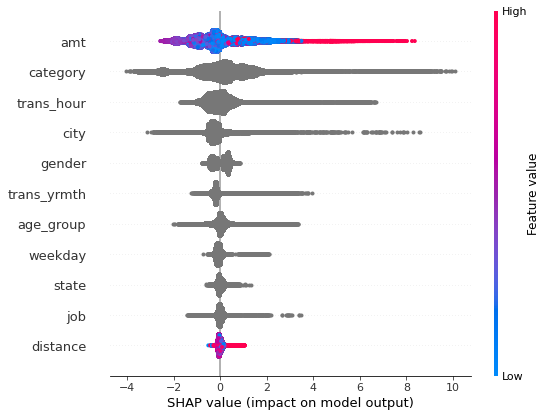

In [ ]:
shap_values = clf4.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_variables), 
                                                                     type="ShapValues")
shap_values = shap_values[:,:-1]

shap.summary_plot(shap_values, X_test)

In [ ]:
from sklearn.metrics import log_loss

def get_feature_imp_plot(method):
    fi = clf4.get_feature_importance(Pool(X_test, label=y_test,cat_features=categorical_variables), 
                                                                     type=method)
    
    feature_score = pd.DataFrame(list(zip(X_test.dtypes.index, fi )),
                                    columns=['Feature','Score'])

    feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

    plt.rcParams["figure.figsize"] = (12,7)
    ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
    ax.set_title("Feature Importance using {}".format(method), fontsize = 14)
    ax.set_xlabel("features")
    plt.show()

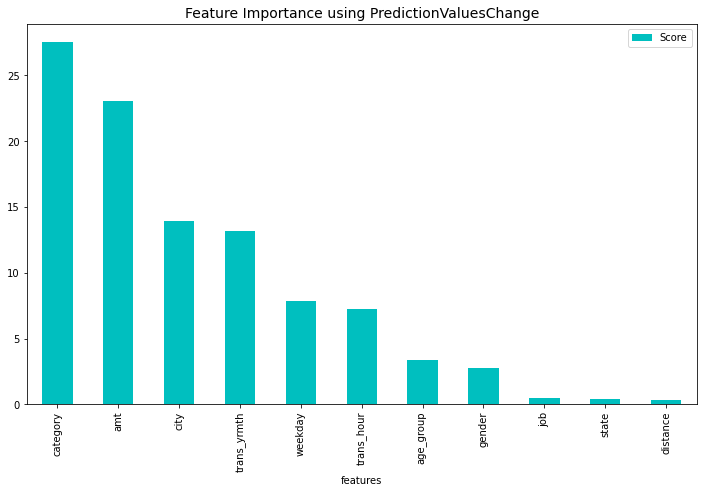

In [ ]:
get_feature_imp_plot(method="PredictionValuesChange")

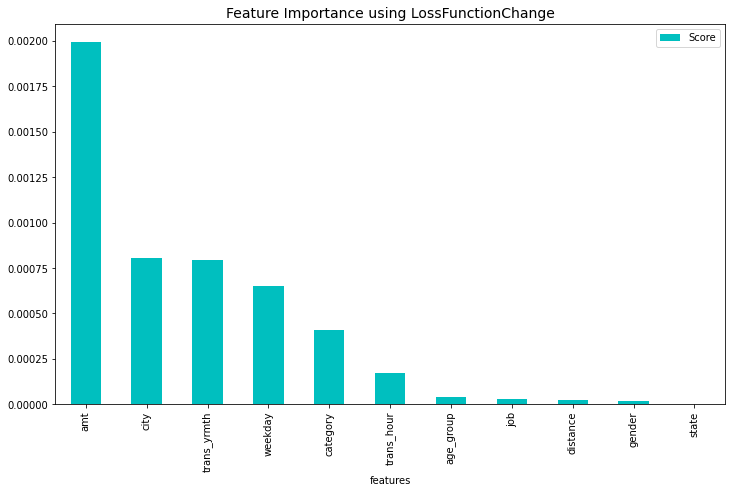

In [ ]:
get_feature_imp_plot(method="LossFunctionChange")